In [22]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [23]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import pyepo
from sklearn.model_selection import train_test_split
from src.models.LinearRegression import LinearRegression

from src.solvers.spnia_asym import AsymmetricSPNI
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid
from src.solvers.BendersDecomposition import BendersDecomposition
from data.DataGenerator import DataGenerator
from models.trainer import Trainer

In [24]:
# Define hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = 0.6
B = 5
network = (6, 8)
random_seed = 31

# ML hyperparameters
num_features = 5
num_data_samples = 100
test_size = 0.2
data_loader_batch_size = 32
epochs = 5

# Set the random seed for reproducibility
np.random.seed(random_seed)

In [25]:
# Define a graph with appropriate dimensions and an opt_model 
# for solving the shortest path problem on the graph
graph = ShortestPathGrid(network[0], network[1])
opt_model = shortestPathGrb(graph)

In [32]:
# # Generate artificial data samples
# data_gen = DataGenerator(
#     num_costs=graph.num_cost,
#     num_features=num_features,
#     cost_feature_map="PolynomialKernel",
#     c_range=(c_min, c_max),
#     epsilon_bar=0.05
# )
# costs, features = data_gen.generate_data(num_samples=num_data_samples)

features, costs = pyepo.data.shortestpath.genData(
    1000, 
    num_features, 
    (graph.m, graph.n), 
    deg=3, 
    noise_width=0.05, 
    seed=31
)

# Split the data into training and testing sets
X_train, X_test, c_train, c_test = train_test_split(features, costs, test_size=test_size, random_state=random_seed)

# Create data loaders for training and testing
optnet_train_dataset = pyepo.data.dataset.optDataset(opt_model, X_train, c_train)
optnet_test_dataset = pyepo.data.dataset.optDataset(opt_model, X_test, c_test)

optnet_train_loader = torch.utils.data.DataLoader(optnet_train_dataset, batch_size=data_loader_batch_size, shuffle=True)
optnet_test_loader = torch.utils.data.DataLoader(optnet_test_dataset, batch_size=data_loader_batch_size, shuffle=False)


Optimizing for optDataset...


100%|██████████| 800/800 [00:00<00:00, 1773.50it/s]

Optimizing for optDataset...



100%|██████████| 200/200 [00:00<00:00, 1772.01it/s]


## Predict-then-Optimize

In [33]:
# 1) Define your network dimensions
input_size  =  num_features   # e.g. number of features in your cost‐vector
hidden_size =  64   # number of neurons in the hidden layer
output_size =  graph.num_cost   # e.g. # of target outputs, or number of classes

# 2) Build the model with nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),  # first affine layer
    nn.ReLU(),                           # non‐linearity
    nn.Linear(hidden_size, output_size),  # second affine layer
    nn.Sigmoid()                         # output activation function
)

# 3) Define device and move the model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4) Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5) Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(c_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=data_loader_batch_size, shuffle=True)

In [35]:
# Define loss and regret vectors
losses = []
regrets = []

# Training loop
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(x_batch)
        loss   = criterion(y_pred, y_batch)

        # Backprop + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    regrets.append(pyepo.metric.regret(model, opt_model, optnet_train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Regret: {regrets[-1]:.4f}")


Epoch 1, Loss: 0.1010, Regret: 0.0535
Epoch 2, Loss: 0.1347, Regret: 0.0497
Epoch 3, Loss: 0.0511, Regret: 0.0471
Epoch 4, Loss: 0.1546, Regret: 0.0448
Epoch 5, Loss: 0.0516, Regret: 0.0443


## Smart Predict-then-Optimize with OptNet

In [ ]:
# Create data loaders for training and testing
train_dataset = pyepo.data.dataset.optDataset(opt_model, X_train, c_train)
test_dataset = pyepo.data.dataset.optDataset(opt_model, X_test, c_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=data_loader_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=data_loader_batch_size, shuffle=False)

In [ ]:
# Instantiate linear regression model
# model = LinearRegression(num_feat=num_features, num_edges=graph.num_cost)

# 1) Define your network dimensions
input_size  =  num_features   # e.g. number of features in your cost‐vector
hidden_size =  64   # number of neurons in the hidden layer
output_size =  graph.num_cost   # e.g. # of target outputs, or number of classes

# 2) Build the model with nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),  # first affine layer
    nn.ReLU(),                           # non‐linearity
    nn.Linear(hidden_size, output_size)  # second affine layer
)

# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model, processes=1)

# Init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=.1)

Num of cores: 1


Epoch 00 | Train Loss: 4.9678 | Train Regret: 0.0436 | Test Loss: 2.7643 | Test Regret: 0.0470
Epoch 01 | Train Loss: 2.3992 | Train Regret: 0.0349 | Test Loss: 2.3677 | Test Regret: 0.0432
Epoch 02 | Train Loss: 2.1322 | Train Regret: 0.0361 | Test Loss: 2.2780 | Test Regret: 0.0374
Epoch 03 | Train Loss: 1.8818 | Train Regret: 0.0267 | Test Loss: 2.2053 | Test Regret: 0.0346
Epoch 04 | Train Loss: 2.0106 | Train Regret: 0.0361 | Test Loss: 2.1027 | Test Regret: 0.0475


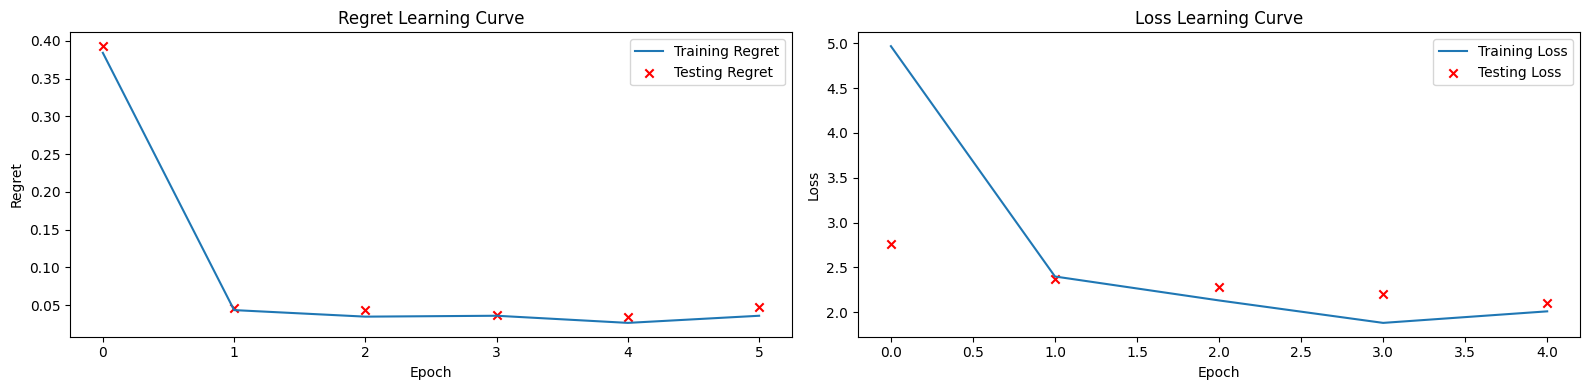

Final regret on test set:  0.04753342651479679


In [21]:
# Create a trainer instance
trainer = Trainer(pred_model=model, 
                  opt_model=opt_model, 
                  optimizer=optimizer, 
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(train_loader, test_loader, epochs=epochs)

# Plot the learning curve
Trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])